In [1]:
%load_ext autoreload
%autoreload 2

from utils import *
import numpy as np
import pandas as pd
import sys
sys.path.append("..")

from torch.utils import data

import glob
import random
import os
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO

from bokeh.io import push_notebook, show, output_notebook,reset_output
from bokeh.plotting import figure
import networkx as nx
from bokeh.plotting import figure, from_networkx, curdoc
from bokeh.models import Rect, HoverTool,  TextInput, GraphRenderer, Circle
from bokeh.io import output_file
from bokeh.plotting import figure, output_file, save
from bokeh.models import (BoxZoomTool, Circle, Line, HoverTool,
                          MultiLine, Plot, Range1d, ResetTool)
from bokeh.models import LinearColorMapper, BasicTicker, ColorBar,CustomJSHover,CustomJS
from bokeh.models import Ellipse, GraphRenderer, StaticLayoutProvider

import grandalf
import warnings
warnings.filterwarnings('ignore')

output_notebook()

%load_ext autoreload
%autoreload 2

Loading BokehJS ...

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
QDIR = os.path.join("/Users/pari/LatencyCollector/queries")
JOB_QNAMES = get_qnames(os.path.join(QDIR, "job"))
CEB_QNAMES = get_qnames(os.path.join(QDIR, "ceb-small"))
ERG_QNAMES = get_qnames(os.path.join(QDIR, "ergast-small"))
STATS_QNAMES = get_qnames(os.path.join(QDIR, "stats"))
JOBLT_QNAMES = get_qnames(os.path.join(QDIR, "joblight_train"))
STACK_QNAMES = get_qnames(os.path.join(QDIR, "stack-small"))
TPCH_QNAMES = get_qnames(os.path.join(QDIR, "tpch"))
ACC_QNAMES = get_qnames(os.path.join(QDIR, "accidents"))


LT_FN = "lt_instances.txt"

#EXP_NAMES = ["exp2_stack"]
#EXP_NAMES = ["exp3_stack_multi1"]
#EXP_NAMES = ["exp4_ceb2"]
#EXP_NAMES = ["exp5_tpch_stats_ergast"]
#EXP_NAMES = ["exp1"]

#EXP_NAMES = ["exp11_multi4_stack"]
#EXP_NAMES = ["exp9_stack1", "exp9_stack2"]

#EXP_NAMES = ["exp10_multi4_1p_imdb"]
#EXP_NAMES = ["exp12_multi4_tpch_stats_ergast"]

#EXP_NAMES = ["exp10_multi4_1p_imdb"]

EXP_NAMES = ["exp13_r7r6-c"]
#EXP_NAMES = ["exp6_multi4b"]

#EXP_NAMES = ["exp7_multi4"]

#EXP_NAMES = ["exp11_multi4"]


#EXP_NAMES = ["exp1_single", "exp2_single", "exp3_single"]
#EXP_NAMES = ["exp3_single"]

#EXP_NAMES = ["exp8_single_stack"]
#EXP_NAMES = ["exp5_single_stats"]
#EXP_NAMES = ["exp6_single_joblight"]
#EXP_NAMES = ["exp7_single_ceb2"]
#EXP_NAMES = ["exp11_single_zdbs"]
#EXP_NAMES = ["exp4_single_ergast"]
#EXP_NAMES = ["exp9_single_tpch"]

#RESULTDIR = os.path.join("/Users/pari/prism-testbed/", "LatencyCollectorResults", "new", EXP_NAME)

LT_TYPES = '''a1_large_mag_4g=lt-0d15fb8f5bbe9a27d
a1_large_gp3_4g=lt-04840b55d3f795395
r7g_large_gp2_16g=lt-0212ec953ba35b176
t3_large_gp2_8g=lt-05d2d354bc3dd9133
c5a_large_mag_4g=lt-03218e9e27718bbbe
m6a_large_mag_8g=lt-0f6f46002652f9a4c
t3a_medium_gp3_4g=lt-0af65294350b1a8c1
t3a_large_gp3_8g=lt-084bfbae110d52d4e
r6a_large_mag_16g=lt-0e608666ff3adff07
t4g_large_mag_8g=lt-04e0b4826c63bfadb
c7g_large_mag_4g=lt-0af47c6caa3b53b8b
r7g_medium_gp2_16g=lt-01d0081183a7d79f2
t3_xlarge_gp2_16g=lt-0b413bcc22b3ac8fb
r7g_large_mag=lt-0f065795841a5648f
'''

lt_types = pd.read_csv(StringIO(LT_TYPES), sep="=", header=None, 
                       names=["lt_type", "lt"])
# ltdf = pd.read_csv(os.path.join(RESULTDIR, LT_FN), header=None, 
#                    names=["instance", "lt"])
# ltdf = ltdf.merge(lt_types, on="lt")
# ltdf

In [3]:
print(EXP_NAMES)

['exp13_r7r6-c']


In [4]:
# print(os.path.exists(RESULTDIR))

dfs = []
bdfs = []

for exp in EXP_NAMES:
    resultdir = os.path.join("/Users/pari/prism-testbed/", "LatencyCollectorResults", "background", exp)
    assert os.path.exists(resultdir)
    ltdf = pd.read_csv(os.path.join(resultdir, LT_FN), header=None, 
                   names=["instance", "lt"])
    
    ltdf = ltdf.merge(lt_types, on="lt")
    
    rtfns = glob.iglob(resultdir + "/*/results/Runtime*.csv")
    bkfns = glob.iglob(resultdir + "/*/results/Background*.csv")

    for ri,rtfn in enumerate(rtfns):
        instance_name = os.path.basename(os.path.dirname(os.path.dirname(rtfn)))
        try:
            rt = pd.read_csv(rtfn, error_bad_lines=False, skipfooter=1)
        except Exception as e:
            print("Exception: ", e)
            continue
        
        rt["instance"] = instance_name
        rt = rt.merge(ltdf, on="instance")
        if len(rt) == 0:
            #print(instance_name)
            continue
        mintime = min(rt["start_time"].values)
        rt["relative_start_time"] = rt.apply(lambda x: x["start_time"]-mintime , axis=1)
        dfs.append(rt)
        
    for bkfn in bkfns:
        #print(bkfn)
        instance_name = os.path.basename(os.path.dirname(os.path.dirname(bkfn)))
        try:
            bk = pd.read_csv(bkfn, error_bad_lines=False, skipfooter=1)
        except:
            continue
        
        bk["instance"] = instance_name
        bk = bk.merge(ltdf, on="instance")
        if len(bk) == 0:
            continue
        bdfs.append(bk)
    
df = pd.concat(dfs)

if len(bdfs) != 0:
    bdf = pd.concat(bdfs)

In [5]:
def get_bk_kind(bdf, start_time, runtime):
    tmp = bdf[bdf["timestamp"] < start_time]
    tmp = tmp[tmp["end_timestamp"] > start_time]
    if len(tmp) == 0:
        #print(tmp)
        return "None"
    #tmp = tmp[tmp["timestamp"] == max(tmp["timestamp"])]
    #assert len(tmp) <= 1
    
    if len(tmp) == 0:
        return "None"
    vals = list(tmp["kind"].values)
    vals.sort()
    return "-".join(vals)

In [6]:
minbdf = min(bdf["timestamp"])
maxbdf = max(bdf["timestamp"])
print("Total background processes: ", maxbdf-minbdf)
bdf["runtime"] = bdf.apply(lambda x: x["end_timestamp"]-x["timestamp"], axis=1)

Total background processes:  78267.6899766922


In [7]:
bdf.groupby("cmd")["runtime"].describe()

,count,mean,std,min,25%,50%,75%,max
cmd,,,,,,,,
bash /home/ubuntu/LatencyCollector/scripts/linux_workloads/ansibench.sh,4.0,2858.881801,170.947994,2610.115762,2816.172740,2921.518115,2964.227177,2982.375213
bash /home/ubuntu/LatencyCollector/scripts/linux_workloads/bonnie.sh,3.0,7412.082082,480.202877,6907.368164,7186.476873,7465.585581,7664.439041,7863.292502
bash /home/ubuntu/LatencyCollector/scripts/linux_workloads/cgrep.sh,7.0,808.824837,317.914118,538.710040,693.204445,701.105804,765.848111,1503.852904
bash /home/ubuntu/LatencyCollector/scripts/linux_workloads/cpp_bench.sh,7.0,1373.627817,190.351368,1157.202290,1195.216639,1436.517686,1506.002021,1619.237425
bash /home/ubuntu/LatencyCollector/scripts/linux_workloads/datasci_bench.sh,2.0,54.460628,2.046556,53.013494,53.737061,54.460628,55.184194,55.907761
bash /home/ubuntu/LatencyCollector/scripts/linux_workloads/ffmpeg.sh,4.0,1359.769266,149.585800,1233.346878,1239.373596,1331.853417,1452.249087,1542.023353
bash /home/ubuntu/LatencyCollector/scripts/linux_workloads/fio.sh,5.0,4047.263379,240.538522,3766.343257,3943.967099,3993.871490,4119.017052,4413.117997
bash /home/ubuntu/LatencyCollector/scripts/linux_workloads/hayden.sh,3.0,3217.881144,545.269870,2591.854330,3032.275244,3472.696158,3530.894550,3589.092942
bash /home/ubuntu/LatencyCollector/scripts/linux_workloads/interbench.sh,2.0,35379.531873,2109.692942,33887.753687,34633.642780,35379.531873,36125.420966,36871.310059


In [160]:
dfs = []

if len(bdfs) != 0:
    bdfs = []
    for instance in set(df["instance"]):
        tmp = df[df["instance"] == instance]
        btmp = bdf[bdf["instance"] == instance]
        tmp["bk_kind"] = tmp.apply(lambda x: get_bk_kind(btmp, x["start_time"], x["runtime"]) , axis=1)
        dfs.append(tmp)
        
    df = pd.concat(dfs)
else:
    df["bk_kind"] = "None"

In [161]:
df = df[df["runtime"] >= 0.0]

In [162]:
print(df["runtime"].sum())
print(df["runtime"].describe())
print(df.keys())
print(bdf.keys())

130708.42802143097
count    1937.000000
mean       67.479829
std       168.028145
min         0.003205
25%         0.920632
50%         5.417821
75%        35.040784
max       909.000000
Name: runtime, dtype: float64
Index(['start_time', 'qname', 'runtime', 'exp_analyze', 'samples_type',
       'bg_seed', 'num_background', 'parallel_workers', 'no_index',
       'drop_cache', 'result_dir', 'query_dir', 'cost_model', 'materialize',
       'explain', 'reps', 'num_queries', 'timeout', 'rerun_timeouts',
       'db_name', 'db_host', 'user', 'pwd', 'port', 'instance', 'lt',
       'lt_type', 'relative_start_time', 'bk_kind'],
      dtype='object')
Index(['timestamp', 'end_timestamp', 'cmd', 'kind', 'instance', 'lt',
       'lt_type', 'runtime'],
      dtype='object')


In [163]:
#df = df[df["lt_type"] != "r7g_medium_gp2_16g"]

In [164]:
print(len(df.groupby(["lt_type"])["runtime"].describe(percentiles=[0.99])))
df.groupby(["lt_type"])["runtime"].describe(percentiles=[0.99]).round(2)

2


,count,mean,std,min,50%,99%,max
lt_type,,,,,,,
r6a_large_mag_16g,1127.0,53.25,140.49,0.00,4.54,845.44,909.0
r7g_large_mag,810.0,87.28,198.54,0.01,7.12,909.00,909.0


In [165]:
qworkloads = {}
for qname in JOB_QNAMES:
    qworkloads[qname] = "JOB"
for qname in CEB_QNAMES:
    qworkloads[qname] = "CEB"
for qname in ERG_QNAMES:
    qworkloads[qname] = "ErgastF1"
for qname in STATS_QNAMES:
    qworkloads[qname] = "Stats"
for qname in JOBLT_QNAMES:
    qworkloads[qname] = "JOB-LT"
for qname in STACK_QNAMES:
    qworkloads[qname] = "Stack"
for qname in TPCH_QNAMES:
    qworkloads[qname] = "TPCH"
    
df["workload"] = df.apply(lambda x: qworkloads[x["qname"]] , axis=1)

df.groupby(["workload", "lt_type"])["runtime"].describe(percentiles=[0.99]).round(2)

count    mean     std   min    50%     99%    max
workload lt_type                                                             
CEB      r6a_large_mag_16g  450.0  108.34  192.03  0.04  24.06  909.00  909.0
         r7g_large_mag      450.0  138.98  244.69  0.07  20.58  909.00  909.0
JOB      r6a_large_mag_16g  677.0   16.63   70.87  0.00   1.28  305.19  909.0
         r7g_large_mag      360.0   22.67   80.06  0.01   2.48  405.63  909.0

In [147]:
#print(len(df.groupby(["lt_type"])["runtime"].describe(percentiles=[0.99])))
pd.set_option('display.max_rows', 500)
df.groupby(["lt_type", "bk_kind"])["runtime"].describe(percentiles=[0.99]).round(2)

count    mean     std     min  \
lt_type           bk_kind                                                   
r6a_large_mag_16g None                      329.0   12.47   43.13    0.00   
                  cgrep.sh-rambench.sh        6.0  161.76  366.19    0.06   
                  cpp_bench.sh                2.0  462.89  386.59  189.53   
                  rambench.sh-rambench.sh     1.0    1.05     NaN    1.05   
r7g_large_mag     None                      101.0    4.72    7.38    0.01   
                  cpp_bench.sh                2.0  240.06  304.43   24.79   
                  cpp_bench.sh-rambench.sh    4.0  266.65  433.41    0.69   
                  fio.sh                    135.0   32.04   84.72    0.01   
                  lxml.sh                     1.0  157.69     NaN  157.69   
                  percolation.sh              4.0    2.30    4.13    0.02   
                  pybench.sh-rambench.sh      6.0   48.33  106.03    0.26   
                  rambench.sh-rambench.sh     1.0    8.25     NaN    8.25   
                  tinymem.sh                 84.0    4.01    6.01    0.01   

                                               50%     99%     max  
lt_type           bk_kind                                           
r6a_large_mag_16g None                        1.22  204.50  515.39  
                  cgrep.sh-rambench.sh       14.44  864.93  909.00  
                  cpp_bench.sh              462.89  730.78  736.25  
                  rambench.sh-rambench.sh     1.05    1.05    1.05  
r7g_large_mag     None                        1.79   33.76   42.43  
                  cpp_bench.sh              240.06  451.02  455.33  
                  cpp_bench.sh-rambench.sh   78.45  886.13  909.00  
                  fio.sh                      3.32  404.26  633.00  
                  lxml.sh                   157.69  157.69  157.69  
                  percolation.sh              0.35    8.25    8.48  
                  pybench.sh-rambench.sh      4.86  252.02  264.52  
                  rambench.sh-rambench.sh     8.25    8.25    8.25  
                  tinymem.sh                  1.40   22.97   24.69

In [13]:
qworkloads = {}
for qname in JOB_QNAMES:
    qworkloads[qname] = "JOB"
for qname in CEB_QNAMES:
    qworkloads[qname] = "CEB"
for qname in ERG_QNAMES:
    qworkloads[qname] = "ErgastF1"
for qname in STATS_QNAMES:
    qworkloads[qname] = "Stats"
for qname in JOBLT_QNAMES:
    qworkloads[qname] = "JOB-LT"
for qname in STACK_QNAMES:
    qworkloads[qname] = "Stack"
for qname in TPCH_QNAMES:
    qworkloads[qname] = "TPCH"
    
df["workload"] = df.apply(lambda x: qworkloads[x["qname"]] , axis=1)

df.groupby(["workload", "lt_type"])["runtime"].describe(percentiles=[0.99])

count        mean         std       min  \
workload lt_type                                                      
CEB      r6a_large_mag_16g  142.0  244.283240  267.825161  0.488476   
         r7g_large_gp2_16g  822.0   28.508945   63.219040  0.050599   
JOB      r6a_large_mag_16g  677.0   38.465548  117.527245  0.005064   
         r7g_large_gp2_16g  678.0   14.220265   30.523638  0.007625   

                                   50%         99%         max  
workload lt_type                                                
CEB      r6a_large_mag_16g  145.245623  909.000000  909.000000  
         r7g_large_gp2_16g    7.647618  293.323612  641.006153  
JOB      r6a_large_mag_16g    2.967578  615.730752  909.000000  
         r7g_large_gp2_16g    3.134569  173.112495  243.103203

In [14]:
jdf = df[df["workload"] == "JOB"]
cdf = df[df["workload"] == "CEB"]

cdf.groupby(["workload", "lt_type"])["runtime"].describe(percentiles=[0.99])

count        mean         std       min  \
workload lt_type                                                      
CEB      r6a_large_mag_16g  142.0  244.283240  267.825161  0.488476   
         r7g_large_gp2_16g  822.0   28.508945   63.219040  0.050599   

                                   50%         99%         max  
workload lt_type                                                
CEB      r6a_large_mag_16g  145.245623  909.000000  909.000000  
         r7g_large_gp2_16g    7.647618  293.323612  641.006153

In [15]:
df.groupby(["workload", "lt_type"])["runtime"].describe(percentiles=[0.99])

count        mean         std       min  \
workload lt_type                                                      
CEB      r6a_large_mag_16g  142.0  244.283240  267.825161  0.488476   
         r7g_large_gp2_16g  822.0   28.508945   63.219040  0.050599   
JOB      r6a_large_mag_16g  677.0   38.465548  117.527245  0.005064   
         r7g_large_gp2_16g  678.0   14.220265   30.523638  0.007625   

                                   50%         99%         max  
workload lt_type                                                
CEB      r6a_large_mag_16g  145.245623  909.000000  909.000000  
         r7g_large_gp2_16g    7.647618  293.323612  641.006153  
JOB      r6a_large_mag_16g    2.967578  615.730752  909.000000  
         r7g_large_gp2_16g    3.134569  173.112495  243.103203

In [116]:
tmp = df[~df["bk_kind"].str.contains("interbench")]
tmp.groupby(["workload", "lt_type"])["runtime"].describe(percentiles=[0.99])

count        mean         std        min  \
workload lt_type                                                       
CEB      r6a_large_mag_16g   14.0  296.599076  311.497185  16.988456   
         r7g_large_gp2_16g  583.0   21.019127   53.431030   0.050599   
JOB      r6a_large_mag_16g  677.0   38.465548  117.527245   0.005064   
         r7g_large_gp2_16g  408.0   10.247421   25.467331   0.007625   

                                   50%         99%         max  
workload lt_type                                                
CEB      r6a_large_mag_16g  173.101294  909.000000  909.000000  
         r7g_large_gp2_16g    5.936926  266.324485  591.778106  
JOB      r6a_large_mag_16g    2.967578  615.730752  909.000000  
         r7g_large_gp2_16g    1.985135  132.840062  243.103203

In [16]:
# tmp = df.groupby(["lt_type", "qname"])["runtime"].mean().reset_index()
# #tmp
# # dfp = tmp.pivot('lt_type', 'lt_type')
# # dfp.corr()

In [17]:
df.groupby(["qname","lt_type","bk_kind"])["runtime"].describe().sort_values(by="std", ascending=False).head(60)

count  \
qname                                        lt_type           bk_kind                  
17b.sql                                      r6a_large_mag_16g hayden.sh          3.0   
6d.sql                                       r6a_large_mag_16g hayden.sh          3.0   
20a.sql                                      r6a_large_mag_16g hayden.sh          2.0   
16d.sql                                      r6a_large_mag_16g learned_sort.sh    2.0   
                                                               None               2.0   
17c.sql                                      r6a_large_mag_16g hayden.sh          3.0   
6f.sql                                       r6a_large_mag_16g hayden.sh          2.0   
26c.sql                                      r6a_large_mag_16g hayden.sh          3.0   
7c.sql                                       r6a_large_mag_16g hayden.sh          3.0   
10c.sql                                      r6a_large_mag_16g hayden.sh          2.0   
7a121.sql                                    r7g_large_gp2_16g rambench.sh        2.0   
20c.sql                                      r6a_large_mag_16g hayden.sh          3.0   
18b.sql                                      r6a_large_mag_16g hayden.sh          3.0   
6d.sql                                       r7g_large_gp2_16g interbench.sh      2.0   
19d.sql                                      r6a_large_mag_16g hayden.sh          3.0   
                                             r7g_large_gp2_16g lxml.sh            2.0   
22c.sql                                      r6a_large_mag_16g cpp_bench.sh       2.0   
18a.sql                                      r7g_large_gp2_16g interbench.sh      3.0   
13c.sql                                      r6a_large_mag_16g hayden.sh          3.0   
13a.sql                                      r6a_large_mag_16g hayden.sh          3.0   
3c.sql                                       r6a_large_mag_16g hayden.sh          3.0   
17a.sql                                      r7g_large_gp2_16g lxml.sh            2.0   
7d421e4bdbe3f7647e9fc2779e46e506528923bf.sql r7g_large_gp2_16g ffmpeg.sh          2.0   
17e.sql                                      r7g_large_gp2_16g interbench.sh      3.0   
18c.sql                                      r6a_large_mag_16g learned_sort.sh    2.0   
2b319.sql                                    r7g_large_gp2_16g None               2.0   
24a.sql                                      r6a_large_mag_16g hayden.sh          3.0   
1c5f97812dda6ec50a10ed2a5e3bbd5b59408075.sql r7g_large_gp2_16g None               2.0   
25a.sql                                      r6a_large_mag_16g hayden.sh          3.0   
8a.sql                                       r7g_large_gp2_16g interbench.sh      2.0   
17d.sql                                      r6a_large_mag_16g hayden.sh          3.0   
b1a7806028abd383d799eddadf7a40ebc9e049a8.sql r7g_large_gp2_16g ffmpeg.sh          2.0   
16b.sql                                      r7g_large_gp2_16g lxml.sh            2.0   
15d.sql                                      r7g_large_gp2_16g interbench.sh      3.0   
23a.sql                                      r6a_large_mag_16g hayden.sh          3.0   
9a.sql                                       r6a_large_mag_16g hayden.sh          3.0   
23c.sql                                      r6a_large_mag_16g None               2.0   
1f4eb208fe38c39bd9323678513a82825ee1a0e2.sql r7g_large_gp2_16g None               2.0   
9c.sql                                       r6a_large_mag_16g hayden.sh          3.0   
7a131.sql                                    r7g_large_gp2_16g None               2.0   
9b.sql                                       r6a_large_mag_16g hayden.sh          3.0   
13d.sql                                      r6a_large_mag_16g hayden.sh          2.0   
30c.sql                                      r7g_large_gp2_16g lxml.sh            2.0   
8a397.sql                                    r7g_large_gp2_16g None        

In [18]:
tmp = df[~df["lt_type"].str.contains("gp2")]
tmp.groupby(["qname","lt_type","bk_kind"])["runtime"].describe().sort_values(by="std", ascending=False).head(60)

count        mean         std  \
qname   lt_type           bk_kind                                          
17b.sql r6a_large_mag_16g hayden.sh          3.0  359.892851  481.278930   
6d.sql  r6a_large_mag_16g hayden.sh          3.0  239.901017  395.103491   
20a.sql r6a_large_mag_16g hayden.sh          2.0  275.295604  379.618079   
16d.sql r6a_large_mag_16g learned_sort.sh    2.0  217.157900  298.257974   
                          None               2.0  168.644029  233.999069   
17c.sql r6a_large_mag_16g hayden.sh          3.0  126.928816  203.390712   
6f.sql  r6a_large_mag_16g hayden.sh          2.0  131.835698  173.197859   
26c.sql r6a_large_mag_16g hayden.sh          3.0  115.282489  163.769099   
7c.sql  r6a_large_mag_16g hayden.sh          3.0  201.786351  152.477124   
10c.sql r6a_large_mag_16g hayden.sh          2.0  154.879722  145.301591   
20c.sql r6a_large_mag_16g hayden.sh          3.0  142.200842  121.526758   
18b.sql r6a_large_mag_16g hayden.sh          3.0   70.341529  120.724273   
19d.sql r6a_large_mag_16g hayden.sh          3.0  123.671653  115.022432   
22c.sql r6a_large_mag_16g cpp_bench.sh       2.0  145.617798  103.933816   
13c.sql r6a_large_mag_16g hayden.sh          3.0   57.753031   92.896751   
13a.sql r6a_large_mag_16g hayden.sh          3.0   57.957233   84.081227   
3c.sql  r6a_large_mag_16g hayden.sh          3.0   48.761208   79.735816   
18c.sql r6a_large_mag_16g learned_sort.sh    2.0   83.123474   62.744504   
24a.sql r6a_large_mag_16g hayden.sh          3.0   37.236386   59.348884   
25a.sql r6a_large_mag_16g hayden.sh          3.0   38.145376   56.788491   
17d.sql r6a_large_mag_16g hayden.sh          3.0   44.336239   51.843027   
23a.sql r6a_large_mag_16g hayden.sh          3.0   28.171861   46.604284   
9a.sql  r6a_large_mag_16g hayden.sh          3.0   28.094276   45.621537   
23c.sql r6a_large_mag_16g None               2.0   32.150370   44.287731   
9c.sql  r6a_large_mag_16g hayden.sh          3.0   46.742359   43.167960   
9b.sql  r6a_large_mag_16g hayden.sh          3.0   25.982388   42.691364   
13d.sql r6a_large_mag_16g hayden.sh          2.0   41.203460   42.648740   
25c.sql r6a_large_mag_16g hayden.sh          2.0   37.575409   35.590104   
15c.sql r6a_large_mag_16g hayden.sh          3.0   39.125451   33.707878   
10b.sql r6a_large_mag_16g hayden.sh          3.0   20.240807   32.894578   
12c.sql r6a_large_mag_16g hayden.sh          3.0   21.697460   32.880917   
25b.sql r6a_large_mag_16g hayden.sh          3.0   18.601437   30.973034   
8d.sql  r6a_large_mag_16g hayden.sh          3.0   32.381493   30.046269   
15a.sql r6a_large_mag_16g hayden.sh          3.0   22.925423   27.184917   
18c.sql r6a_large_mag_16g hayden.sh          2.0   47.096785   24.392627   
5c.sql  r6a_large_mag_16g hayden.sh          3.0   13.134691   21.369600   
26a.sql r6a_large_mag_16g hayden.sh          3.0   16.247469   20.931795   
14c.sql r6a_large_mag_16g hayden.sh          2.0   14.337840   18.752616   
7a.sql  r6a_large_mag_16g hayden.sh          2.0   14.680141   18.220644   
19b.sql r6a_large_mag_16g hayden.sh          2.0   13.342956   17.755901   
12a.sql r6a_large_mag_16g hayden.sh          3.0   11.012363   17.387412   
15d.sql r6a_large_mag_16g learned_sort.sh    2.0   19.065747   15.475502   
10a.sql r6a_large_mag_16g hayden.sh          3.0   17.243365   13.430778   
22d.sql r6a_large_mag_16g learned_sort.sh    2.0   11.792335   13.425661   
15d.sql r6a_large_mag_16g hayden.sh          2.0   11.081747    9.990665   
31c.sql r6a_large_mag_16g hayden.sh          3.0   10.771288    7.928755   
13d.sql r6a_large_mag_16g learned_sort.sh    2.0   16.741683    7.748192   
8c.sql  r6a_large_mag_16g hayden.sh          2.0   26.069957    7.222427   
9d.sql  r6a_large_mag_16g hayden.sh          2.0   21.268076    6.685421   
16b.sql r6a_large_mag_16g hayden.sh          3.0   41.658255    6.487907   
29c.sql r6a_large_mag_16g hayden.sh          3.0   23.164443    5.918160   
17e.sql r6a_lar

In [19]:
# mintime = min(df["start_time"])
# df["relative_start_time"] = df.apply(lambda x: x["start_time"]-mintime , axis=1)

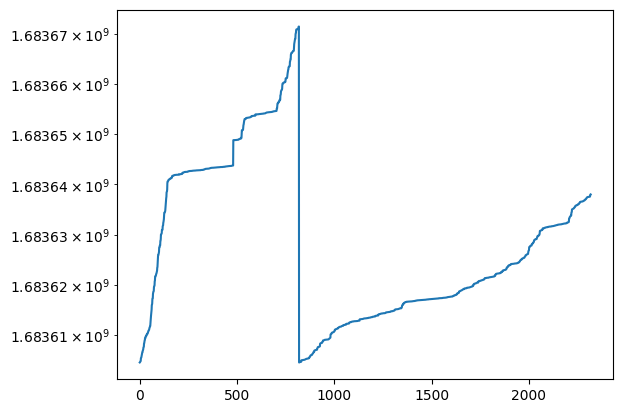

In [20]:
sns.lineplot(x=range(len(df["start_time"])), y=df["start_time"].values)
plt.yscale("log")

In [21]:
print(len(set(df["qname"])))

263


In [22]:
tmp = df[df["qname"] == "8a.sql"]
tmp[["relative_start_time", "qname", "runtime"]]

,relative_start_time,qname,runtime
223,37766.093795,8a.sql,14.447967
336,38456.950366,8a.sql,8.202867
449,39001.485227,8a.sql,4.200021
577,48990.171526,8a.sql,16.714945
690,49936.232362,8a.sql,19.876284
803,65521.150829,8a.sql,536.099003
470,10121.387121,8a.sql,25.813803
583,12178.997645,8a.sql,11.845881
696,12651.574546,8a.sql,4.431597
839,14432.171623,8a.sql,19.582858


In [23]:
# tmp1 = df[df["relative_start_time"] < 5800]
# tmp2 = df[df["relative_start_time"] >= 5800]
# tmp2 = tmp2[tmp2["relative_start_time"] < 8000]

<AxesSubplot: >

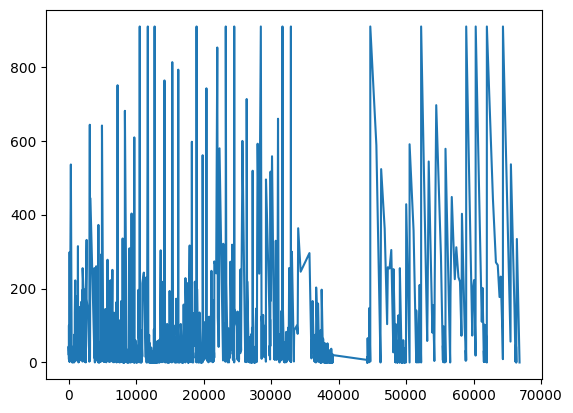

In [24]:
sns.lineplot(x=df["relative_start_time"].values, y=df["runtime"].values)

In [25]:
logfns = glob.iglob(resultdir + "/*/results/sar_logs*")
list(logfns)

['/Users/pari/prism-testbed/LatencyCollectorResults/background/exp13_r7r6/i-0fd1dd9aa414cb9f0/results/sar_logs.csv',
 '/Users/pari/prism-testbed/LatencyCollectorResults/background/exp13_r7r6/i-0fd1dd9aa414cb9f0/results/sar_logs00',
 '/Users/pari/prism-testbed/LatencyCollectorResults/background/exp13_r7r6/i-0fd1dd9aa414cb9f0/results/sar_logs07',
 '/Users/pari/prism-testbed/LatencyCollectorResults/background/exp13_r7r6/i-0fd1dd9aa414cb9f0/results/sar_logs31',
 '/Users/pari/prism-testbed/LatencyCollectorResults/background/exp13_r7r6/i-0fd1dd9aa414cb9f0/results/sar_logs36',
 '/Users/pari/prism-testbed/LatencyCollectorResults/background/exp13_r7r6/i-0fd1dd9aa414cb9f0/results/sar_logs09',
 '/Users/pari/prism-testbed/LatencyCollectorResults/background/exp13_r7r6/i-0fd1dd9aa414cb9f0/results/sar_logs37',
 '/Users/pari/prism-testbed/LatencyCollectorResults/background/exp13_r7r6/i-0fd1dd9aa414cb9f0/results/sar_logs08',
 '/Users/pari/prism-testbed/LatencyCollectorResults/background/exp13_r7r6/i-0f

In [26]:

#logdfs = defaultdict(list)

all_logdfs = {}
for exp in EXP_NAMES:
    resultdir = os.path.join("/Users/pari/prism-testbed/", "LatencyCollectorResults", "background", exp)
    
    #logdfs = {}
    logfns = glob.iglob(resultdir + "/*/results/sar_logs*")
    #print(list(logfns))
    instance_dirs = os.listdir(resultdir)
    for iname in instance_dirs:
        if os.path.isdir(os.path.join(resultdir, iname)):
            all_logdfs[iname] = {}
        else:
            print(iname)
    
    ltdf = pd.read_csv(os.path.join(resultdir, LT_FN), header=None, 
           names=["instance", "lt"])
    ltdf = ltdf.merge(lt_types, on="lt")
    
    for fi, fn in enumerate(logfns):
        instance_name = os.path.basename(os.path.dirname(os.path.dirname(fn)))
        #print(instance_name)
        #all_logdfs[instance_name] = logdfs
        logdfs = all_logdfs[instance_name]

        if ".csv" in fn or "sar_logs00" in fn:
            continue
        try:
            curdf = pd.read_csv(fn, delimiter=";")
            #curdf["instance"] = instance_name
            #curdf = curdf.merge(ltdf, on="instance")
        except Exception as e:
            print("Exception@")
            print(e)
            continue

        if 'kbmemfree' in curdf.keys():
            logdfs["mem"] = curdf
        elif "dropd/s" in curdf.keys():
            logdfs["network1"] = curdf
        elif "%sio-10" in curdf.keys():
            #system load and pressure-stall statistics
            logdfs["pressure_io"] = curdf
        elif 'kbhugfree' in curdf.keys():
            logdfs["hugepg"] = curdf
        elif '%smem-10' in curdf.keys():
            logdfs["pressure_mem"] = curdf
        elif 'kbswpfree' in curdf.keys():
            logdfs["swap"] = curdf
        elif 'idgm6/s' in curdf.keys():
            logdfs["network2"] = curdf
        elif 'bdscd/s' in curdf.keys():
            logdfs["io1"] = curdf
        elif '%irq' in curdf.keys():
            logdfs["cpu_utilization"] = curdf
        elif 'atmptf/s' in curdf.keys():
            logdfs["network3"] = curdf
        elif 'idgm/s' in curdf.keys():
            logdfs["network4"] = curdf
        elif 'areq-sz' in curdf.keys():
            logdfs["device_io"] = curdf
        elif 'call/s' in curdf.keys():
            logdfs["network_nfs"] = curdf
        elif 'rxdrop/s' in curdf.keys():
            logdfs["network5"] = curdf
        elif 'rxcmp/s' in curdf.keys():
            logdfs["network6"] = curdf
        elif 'tcp6sck' in curdf.keys():
            logdfs["network7"] = curdf
        elif 'iseg/s' in curdf.keys():
            logdfs["network8"] = curdf
        elif 'pswpin/s' in curdf.keys():
            logdfs["swap"] = curdf
        elif 'intr/s' in curdf.keys():
            logdfs["interrupts"] = curdf
        elif '%scpu-10' in curdf.keys():
            logdfs["pressure_cpu"] = curdf
        elif 'MHz' in curdf.keys():
            logdfs["power-cpu"] = curdf
        elif 'degC' in curdf.keys():
            logdfs["power-temp"] = curdf
        elif '%ufsused' in curdf.keys():
            logdfs["filesystem"] = curdf
        elif 'cswch/s' in curdf.keys():
            logdfs["context_switch"] = curdf
        elif 'pgpgin/s' in curdf.keys():
            logdfs["paging"] = curdf
        elif 'fwddgm/s' in curdf.keys():
            logdfs["network9"] = curdf
        elif 'ihdrer6/s' in curdf.keys():
            logdfs["network10"] = curdf
        elif 'imsg/s' in curdf.keys():
            logdfs["network11"] = curdf
        elif 'ierr6/s' in curdf.keys():
            logdfs["network12"] = curdf
        elif 'scall/s' in curdf.keys():
            logdfs["network13"] = curdf
        elif 'runq-sz' in curdf.keys():
            logdfs["pressure_load"] = curdf
        elif 'dentunusd' in curdf.keys():
            logdfs["inode"] = curdf
        elif 'igmbq6/s' in curdf.keys():
            logdfs["network14"] = curdf
        elif 'tcpsck' in curdf.keys():
            logdfs["network15"] = curdf
        elif 'otmex/s' in curdf.keys():
            logdfs["network16"] = curdf
        elif 'ihdrerr/s' in curdf.keys():
            logdfs["network17"] = curdf
        elif 'irec6/s' in curdf.keys():
            logdfs["network18"] = curdf
        else:
            assert False

lt_instances.txt


In [27]:
print("Number of log files: ", len(logdfs))

todel = []
for instance,logdfs in all_logdfs.items():
    keys = list(logdfs.keys())
    tmp = df[df["instance"] == instance]
    if len(tmp) == 0:
        todel.append(instance)
        
for td in todel:
    del all_logdfs[td]

for instance,logdfs in all_logdfs.items():
    print(instance, len(logdfs))
    keys = list(logdfs.keys())
    tmp = df[df["instance"] == instance]

    min_qtime = min(tmp["start_time"].values)
    max_qtime = max(tmp["start_time"].values)

    for k in keys:
        if "network" in k:
            del logdfs[k]
            continue
        if "hugepg" in k:
            del logdfs[k]
            continue

        if len(logdfs[k]) == 0:
            continue

        mincur = min(logdfs[k]["timestamp"])
        logdfs[k]["relative_time"] = logdfs[k].apply(lambda x: x["timestamp"]-min_qtime , axis=1)
        logdfs[k] = logdfs[k][logdfs[k]["relative_time"] >= -10.0]
        
print("Number of log files w/o networking: ", len(logdfs))

Number of log files:  36
i-0fd1dd9aa414cb9f0 36
i-097b0c376f29e23bc 36
Number of log files w/o networking:  16


In [28]:
for instance,logdfs in all_logdfs.items():
    print(logdfs.keys())
    print(min(logdfs["mem"]["relative_time"]))

dict_keys(['mem', 'pressure_io', 'pressure_mem', 'swap', 'io1', 'cpu_utilization', 'device_io', 'interrupts', 'pressure_cpu', 'power-cpu', 'power-temp', 'filesystem', 'context_switch', 'paging', 'pressure_load', 'inode'])
-0.02538442611694336
dict_keys(['mem', 'pressure_io', 'pressure_mem', 'swap', 'io1', 'cpu_utilization', 'device_io', 'interrupts', 'pressure_cpu', 'power-cpu', 'power-temp', 'filesystem', 'context_switch', 'paging', 'pressure_load', 'inode'])
-1.134394884109497


In [29]:
print(all_logdfs.keys())
print(set(df["instance"]))

dict_keys(['i-0fd1dd9aa414cb9f0', 'i-097b0c376f29e23bc'])
{'i-097b0c376f29e23bc', 'i-0fd1dd9aa414cb9f0'}


In [30]:
total = 0
for ldf in logdfs:
    print(ldf, logdfs[ldf].keys())
    total += len(logdfs[ldf].keys())

print("Num data points per timestamp: ", total)

mem Index(['# hostname', 'interval', 'timestamp', 'kbmemfree', 'kbavail',
       'kbmemused', '%memused', 'kbbuffers', 'kbcached', 'kbcommit', '%commit',
       'kbactive', 'kbinact', 'kbdirty', 'kbanonpg', 'kbslab', 'kbkstack',
       'kbpgtbl', 'kbvmused', 'relative_time'],
      dtype='object')
pressure_io Index(['# hostname', 'interval', 'timestamp', '%sio-10', '%sio-60', '%sio-300',
       '%sio', '%fio-10', '%fio-60', '%fio-300', '%fio', 'relative_time'],
      dtype='object')
pressure_mem Index(['# hostname', 'interval', 'timestamp', '%smem-10', '%smem-60',
       '%smem-300', '%smem', '%fmem-10', '%fmem-60', '%fmem-300', '%fmem',
       'relative_time'],
      dtype='object')
swap Index(['# hostname', 'interval', 'timestamp', 'pswpin/s', 'pswpout/s',
       'relative_time'],
      dtype='object')
io1 Index(['# hostname', 'interval', 'timestamp', 'tps', 'rtps', 'wtps', 'dtps',
       'bread/s', 'bwrtn/s', 'bdscd/s', 'relative_time'],
      dtype='object')
cpu_utilization Index([

# Interrupts / s

In [31]:
logdfs["interrupts"].groupby("INTR")["intr/s"].describe()

,count,mean,std,min,25%,50%,75%,max
INTR,,,,,,,,
-1,3535.0,2278.033420,9837.132992,343.10,556.60,669.6,911.60,142285.5
0,3535.0,0.000000,0.000000,0.00,0.00,0.0,0.00,0.0
1,3535.0,0.000000,0.000000,0.00,0.00,0.0,0.00,0.0
2,3535.0,0.000000,0.000000,0.00,0.00,0.0,0.00,0.0
3,3535.0,0.000000,0.000000,0.00,0.00,0.0,0.00,0.0
4,3535.0,0.000000,0.000000,0.00,0.00,0.0,0.00,0.0
5,3535.0,0.000000,0.000000,0.00,0.00,0.0,0.00,0.0
6,3535.0,0.000000,0.000000,0.00,0.00,0.0,0.00,0.0
7,3535.0,0.000000,0.000000,0.00,0.00,0.0,0.00,0.0


# PageFaults / s

In [32]:
# pgdf = logdfs["paging"]
# sns.lineplot(x=pgdf["relative_time"], y=pgdf["fault/s"].values)

<AxesSubplot: >

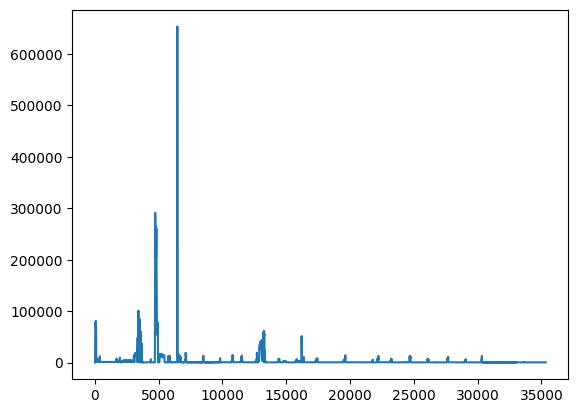

In [33]:
cdf = logdfs["context_switch"]
sns.lineplot(x=cdf["relative_time"].values, y=cdf["cswch/s"].values)

In [34]:
# powdf = logdfs["power-temp"]
# sns.lineplot(x=range(len(powdf)), y=powdf["degC"].values)

In [35]:
# powcpu = logdfs["power-cpu"]
# sns.lineplot(x=range(len(powcpu)), y=powcpu["MHz"].values)

In [36]:
pcpu = logdfs["pressure-cpu"]
sns.lineplot(x=pcpu["relative_time"].values, y=pcpu["%scpu"].values)

KeyError: 'pressure-cpu'

In [ ]:
memdf = logdfs["mem"]
sns.lineplot(x=memdf["relative_time"], y=memdf["%memused"].values)

In [ ]:
logdfs.keys()

In [ ]:
fig,axs = plt.subplots(nrows=1,ncols=1,figsize=(20,6))
sns.lineplot(data=df, x="relative_start_time", y = "runtime", ax=axs)

In [ ]:
# tmp = df[df["runtime"] <= 900.0]

# fig,axs = plt.subplots(nrows=1,ncols=1,figsize=(20,6))
# sns.lineplot(data=tmp, x="relative_start_time", y = "runtime", ax=axs)

In [ ]:
# tmp = df[df["runtime"] <= 900.0]

# fig,axs = plt.subplots(nrows=1,ncols=1,figsize=(20,6))
# sns.histplot(data=tmp, x="relative_start_time", y = "runtime", stat="count", bins=1000, ax=axs)

In [ ]:
#tmp = df[df["runtime"] <= 900.0]

fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(10,6))
sns.scatterplot(data=df, x="relative_start_time", y = "runtime", ax=ax, alpha=0.3)


In [ ]:
logdfs["device_io"].groupby(["DEV"])["areq-sz"].describe()

In [ ]:
print(min(logdfs["paging"]["timestamp"].values), max(logdfs["paging"]["timestamp"].values))
mins = min(logdfs["paging"]["timestamp"].values)
maxs = max(logdfs["paging"]["timestamp"].values)

In [ ]:
print(min(df["start_time"].values), max(df["start_time"].values))
mins2 = min(df["start_time"].values)
maxs2 = max(df["start_time"].values)

In [ ]:
"Seconds after which we started executing queries: ", mins2 - mins

In [ ]:
"Seconds after which we finished executing queries: ", maxs - maxs2

In [ ]:
"Seconds for total sys logging: ", maxs - mins

In [ ]:
"Seconds for total query executions: ", maxs2 - mins2

In [37]:
print(len(set(df["qname"])))

263


In [38]:
# import pandas as pd
# from bokeh.io import curdoc, output_notebook, output_file
# from bokeh.layouts import row, column
# from bokeh.models import Select, DataRange1d, ColumnDataSource
# from bokeh.plotting import figure

# output_notebook()
# # output_file('test.html')

# def get_dataset(src, key):
#     source = ColumnDataSource(data=src)
#     return source


# curdf = logdfs["mem"]
# cc = []
# for key in curdf.keys():
#     if key not in ["# hostname", "interval", "timestamp", "relative_time"]:
#         cc.append(key)

# sel = cc[0]
# # vselect = Select(value=ver, title='Statistic Name', options=sorted((cc)))
# # source = get_dataset(curdf, ver)

# plot = figure(plot_width=500, plot_height = 400, tools="", 
#               toolbar_location=None)
# plot.xaxis.axis_label = 'Unix Seconds'
# plot.yaxis.axis_label = 'Stats'
# plot.axis.axis_label_text_font_style = 'bold'

# plot.grid.grid_line_alpha = 0.3 
# plot.title.text = "System Statistics"

# lines = []
# for key in cc:
#     lines.append(plot.line(x='relative_time', y=key, source=source))
#     lines[-1].visible = False

# select = Select(title="Plot to show:", value=sel, options=cc)

# select.js_on_change("value", CustomJS(args=dict(lines=lines, options=cc), code="""
#     for (let i = 0, len = options.length; i < len; i++) {
#         if (this.value == options[i]) {
#             lines[i].visible = true
#         } else {
#             lines[i].visible = false
#         }
#     }
# """))

# layout = column(select, plot)
# show(layout)

# #show(column(controls, plot))

# Working code for bokeh

In [39]:
# import copy
# import pandas as pd
# from bokeh.io import curdoc, output_notebook, output_file
# from bokeh.layouts import row, column
# from bokeh.models import Select, DataRange1d, ColumnDataSource
# from bokeh.plotting import figure

# output_notebook()

# curdf = logdfs["mem"]
# cc = []
# for key in curdf.keys():
#     if key not in ["# hostname", "interval", "timestamp", "relative_time"]:
#         cc.append(key)

# sel = cc[0]

# src = copy.deepcopy(curdf)
# src["to_plot"] = src[sel]
# source = ColumnDataSource(data=src)

# plot = figure(plot_width=500, plot_height = 400, tools="", 
#               toolbar_location=None)
# plot.xaxis.axis_label = 'Unix Seconds'
# plot.yaxis.axis_label = 'Stats'
# plot.axis.axis_label_text_font_style = 'bold'

# plot.grid.grid_line_alpha = 0.3 
# plot.title.text = "System Statistics"

# plot.line(x='relative_time', y="to_plot", source=source)

# select = Select(title="Statistic", value=sel, options=cc)
# select.js_on_change("value", CustomJS(args=dict(source=source, select=select), code="""
#     source.data["to_plot"] = source.data[this.value];
#     source.change.emit()
# """))

# # fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(10,6))
# # sns.scatterplot(data=df, x="relative_start_time", y = "runtime", ax=ax, alpha=0.3)

# layout = column(select, plot)
# show(layout)

# # output_file('test.html')

In [41]:
import copy
import pandas as pd
from bokeh.io import curdoc, output_notebook, output_file
from bokeh.layouts import row, column
from bokeh.models import Select, DataRange1d, ColumnDataSource, MultiChoice
from bokeh.plotting import figure

def plot_all_instances(all_df):
    
    for instance in all_logdfs:
        
        curlogdfs = all_logdfs[instance]
        df = all_df[all_df["instance"] == instance]
        lttype = df["lt_type"].values[0]
        
        reset_output()
        output_file("Query-System-Logs-{}-{}.html".format(lttype, "imdb2"))

        KEY_ORDER = ["mem", "io1", "device_io", "cpu_utilization", 
                    "pressure_mem", "pressure_io", "pressure_cpu", "pressure_load",
                    "paging", "context_switch", 'interrupts', 'filesystem', 
                     'inode']

        def get_cur_plot(curdf, title, common_xrange, common_x):
            #global common_xrange, common_x

            cc = []
            for key in curdf.keys():
                if key not in ["# hostname", "interval", "timestamp", "relative_time", "DEV", 
                              "FILESYSTEM",]:
                    cc.append(key)

            sel = cc[0]
            src = curdf
            src = src.groupby("relative_time").mean().reset_index()
            src["to_plot"] = src[sel]

            source = ColumnDataSource(data=src)
            
            plot = figure(width=420, height = 400,
              #x_range = common_xrange,
             )
            
            if common_xrange is None:
                common_xrange = plot.x_range
            else:
                source.data["common_relative_time"] = common_x

            plot.xaxis.axis_label = 'Seconds'
            plot.yaxis.axis_label = 'Stat'
            plot.axis.axis_label_text_font_style = 'bold'
            plot.grid.grid_line_alpha = 0.3 
            plot.title.text = title


            if common_x is None:
                plot.line(x='relative_time', y="to_plot", source=source)
                common_x = source.data["relative_time"]
                #common_x = source.data.relative_time
            else:
                plot.line(x="common_relative_time", y="to_plot", source=source)
                #plot.line(x=common_x, y=source.data["to_plot"])

            select = Select(title="Statistic", value=sel, options=cc)
            select.js_on_change("value", CustomJS(args=dict(source=source, select=select), code="""
                source.data["to_plot"] = source.data[this.value];
                source.change.emit()
            """))

            layout = column(select, plot)
            return layout, common_xrange, common_x

        circles = {}
        #df.groupby(["qname"])["runtime"].std().sort_values(by="std", ascending=False).head(60)
        tmp_std = df.groupby(["qname"])["runtime"].std().reset_index().rename(columns={"runtime":"std"})
        
        df = df.merge(tmp_std, on="qname")
        
        hover = HoverTool(tooltips=[
            ('qname', '@qname'),
            ('std', '@std'),
            ('relative_start_time', '@relative_start_time'),
            ('runtime', '@runtime'),
        ])
        
        
        runtime_plot = figure(title = "Query Runtimes", width=1600, height=400, tools=[hover])
        runtime_plot.xaxis.axis_label = 'Seconds'

        allqnames = list(set(df["qname"]))
        for qname in set(df["qname"]):
            tmp = df[df["qname"] == qname]
            rtsource = ColumnDataSource(data=tmp)
            c1 = runtime_plot.circle('relative_start_time','runtime', source=rtsource,
                                     fill_alpha=0.6, size=10)
            c1.visible = True
            circles[qname] = c1

        ### w/o separate circles for scatterplot
        # rtsource = ColumnDataSource(data=df)
        # runtime_plot.circle('relative_start_time','runtime', source=rtsource,fill_alpha=0.5, size=10)

        ### selection area
        multi_choice = MultiChoice(title="Query Selector", value=["all"], options=allqnames + ["all"])
        multi_choice.js_on_change("value", CustomJS(args=dict(circles=circles), code="""
            for (const [key, c1] of Object.entries(circles)) {
                if (this.value.includes("all")) {
                    c1.visible = true
                } else if (this.value.includes(key)) {
                    c1.visible = true
                } else {
                    c1.visible = false
                }
            }
        """))

        plots = []
        
        common_xrange = None
        common_x = None
        
        for key in KEY_ORDER:
            if len(logdfs[key]) == 0:
                continue
            if key in ["swap", "temp"]:
                continue
            p1,common_xrange,common_x = get_cur_plot(curlogdfs[key], key, common_xrange, common_x)
            plots.append(p1)

        show(column(column(multi_choice, runtime_plot), row(plots[0:4]), row(plots[4:8]), row(plots[8:12]), 
                    row(plots[12:16])))
        
plot_all_instances(df)

In [161]:
print(len(all_logdfs.keys()))

11


# Per query plots

In [453]:
reset_output()
output_notebook()

reset_output()
#output_notebook()

FN_TMP = "./{EXP_NAME}/{QNAME}.html"
TITLE_FMT = "{QUERY}.\n Start:{START}.\n Latency:{LAT}."
COLS = 2

make_dir(EXP_NAME)

plot_data = {}

for qi, qname in enumerate(list(set(df["qname"]))):
#     if qi >= 2:
#         break
    
    fn = FN_TMP.format(EXP_NAME=EXP_NAME, QNAME=qname.replace(".sql", ""))
    output_file(fn)
    print(fn)
    
    tmp = df[df["qname"] == qname]
    tmp = tmp.sort_values(by="relative_start_time")
    allplots = []
    
    for ei, exp in enumerate(tmp["exp_analyze"].values):
        try:
            plan = eval(str(exp))
            #print(plan)
        except Exception as e:
            print(e)
            continue
        
        lat = tmp["runtime"].values[ei]
        stime = tmp["relative_start_time"].values[ei]
        title = TITLE_FMT.format(QUERY=qname, START=stime, LAT = lat)

        G = explain_to_nx(plan[0][0][0])
        #print(len(G.nodes()))
        aliases = extract_values(plan[0][0][0], "Alias")
        #print(aliases)

        p1 = bokeh_plot(G, showplot=False,  height=600, width=800, title=title)
        p1.visible = True
        allplots.append(p1)
        
    allrows = []
    num_rows = math.ceil(len(allplots) / COLS)
    
    for i in range(num_rows):
        allrows.append(row(allplots[i*COLS:i*COLS+COLS]))
    
    save(column(allrows))
    #show(column(row(allplots[0:3]), row(allplots[3:6]), row(allplots[6:9])))

Loading BokehJS ...

./t7xlarge-gp3-d/29c.html
./t7xlarge-gp3-d/25b.html
./t7xlarge-gp3-d/23a.html
./t7xlarge-gp3-d/2a714.html
./t7xlarge-gp3-d/6de21f7b6d08d84073c7496dbff73afba95d7c8d.html
./t7xlarge-gp3-d/30b.html
./t7xlarge-gp3-d/18a.html
./t7xlarge-gp3-d/11d.html
./t7xlarge-gp3-d/26b.html
./t7xlarge-gp3-d/24b.html
./t7xlarge-gp3-d/4a143.html
./t7xlarge-gp3-d/32b1cf5e7af7bd6231e2d73a1b56ecf21bbd9804.html
./t7xlarge-gp3-d/3a76.html
./t7xlarge-gp3-d/7a58.html
./t7xlarge-gp3-d/29a.html
./t7xlarge-gp3-d/7045b4dac1171674c69f224b25c3c73ad8d9ca03.html
./t7xlarge-gp3-d/19a.html
./t7xlarge-gp3-d/408f3f94c386672c03af6b01705edab10554bba2.html
./t7xlarge-gp3-d/1a972.html
./t7xlarge-gp3-d/3a315.html
./t7xlarge-gp3-d/1c.html
./t7xlarge-gp3-d/16d.html
./t7xlarge-gp3-d/2c99.html
./t7xlarge-gp3-d/32a.html
./t7xlarge-gp3-d/5b.html
./t7xlarge-gp3-d/8c.html
./t7xlarge-gp3-d/be5f621ca67267a999a86e6b9843728d6992d649.html
./t7xlarge-gp3-d/2a620.html
./t7xlarge-gp3-d/3ebf44254fc9a2ae77481169131fd0ab111a6c43.html
./t7xlarge-gp3

./t7xlarge-gp3-d/20a.html
./t7xlarge-gp3-d/8a400.html
./t7xlarge-gp3-d/2a245.html
./t7xlarge-gp3-d/8d.html
./t7xlarge-gp3-d/30c.html
./t7xlarge-gp3-d/6a508.html
./t7xlarge-gp3-d/15d.html
./t7xlarge-gp3-d/728f1ee9b87457c8b28490639330db5b8f5b1e1c.html
./t7xlarge-gp3-d/6a338.html
./t7xlarge-gp3-d/61959f7b7fcd01bb21afed4e91a731fb1e4f5a14.html
./t7xlarge-gp3-d/1a761.html
./t7xlarge-gp3-d/1a1974.html
./t7xlarge-gp3-d/e8c1806d3f6d16369058ed9c40cc6b4e2e56676e.html
./t7xlarge-gp3-d/2a348.html
./t7xlarge-gp3-d/cd252c4d15a8d118c1aae28bd1ec48c7f45584b2.html
./t7xlarge-gp3-d/14a.html
./t7xlarge-gp3-d/2c192.html
./t7xlarge-gp3-d/5a686.html
./t7xlarge-gp3-d/7a160.html


In [321]:
src.groupby("relative_time").mean().reset_index()

,relative_time,timestamp
0,0,1674686716
1,10,1674686726
2,20,1674686736
3,30,1674686746
4,40,1674686756
...,...,...
2280,22810,1674709526
2281,22820,1674709536
2282,22830,1674709546
2283,22840,1674709556


In [116]:
print(logdfs.keys())
print(len(logdfs.keys()))

dict_keys(['mem', 'pressure1', 'pressure2', 'swap', 'io1', 'cpu_utilization', 'device_io', 'interrupts', 'pressure-cpu', 'power-cpu', 'power-temp', 'filesystem', 'context_switch', 'paging', 'pressure-load', 'inode'])
16


In [644]:
logdfs["mem"].keys()

Index(['# hostname', 'interval', 'timestamp', 'kbmemfree', 'kbavail',
       'kbmemused', '%memused', 'kbbuffers', 'kbcached', 'kbcommit', '%commit',
       'kbactive', 'kbinact', 'kbdirty', 'kbanonpg', 'kbslab', 'kbkstack',
       'kbpgtbl', 'kbvmused'],
      dtype='object')

In [643]:
logdfs.keys()

dict_keys(['mem', 'pressure1', 'hugepg', 'pressure2', 'swap', 'io1', 'cpu_utilization', 'device_io', 'interrupts', 'pressure-cpu', 'power-cpu', 'power-temp', 'filesystem', 'context_switch', 'paging', 'pressure-load', 'inode'])